In [1]:
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
from urllib.parse import urljoin


In [2]:
ARTICLE_URL = "https://pmc.ncbi.nlm.nih.gov/articles/PMC11786524/"

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (X11; Linux x86_64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": ARTICLE_URL
}


In [4]:
!pip install pandas requests beautifulsoup4 lxml

In [6]:
import requests

PMCID_NUM = "11786524"  # from PMCID: PMC11786524
OAI_URL = "https://pmc.ncbi.nlm.nih.gov/api/oai/v1/mh/"
params = {
    "verb": "GetRecord",
    "identifier": f"oai:pubmedcentral.nih.gov:{PMCID_NUM}",
    "metadataPrefix": "pmc"   # full-text XML
}

r = requests.get(OAI_URL, params=params, timeout=30)
r.raise_for_status()

xml_text = r.text
xml_text[:500]


'\n\n\n<OAI-PMH xmlns="http://www.openarchives.org/OAI/2.0/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"\n         xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/ http://www.openarchives.org/OAI/2.0/OAI-PMH.xsd">\n    <responseDate>2026-02-03T03:25:17Z</responseDate>\n    <request verb="GetRecord" identifier="oai:pubmedcentral.nih.gov:11786524" metadataPrefix="pmc">https://pmc.ncbi.nlm.nih.gov/api/oai/v1/mh/</request>\n    \n    <GetRecord>\n        <record>\n    <header>\n    <identifier'

In [7]:
import pandas as pd
from bs4 import BeautifulSoup

soup = BeautifulSoup(xml_text, "xml")

table_wraps = soup.find_all("table-wrap")
len(table_wraps)


5

In [8]:
import re
from datetime import datetime

def safe_name(s):
    s = (s or "").strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s).strip("_")
    return s[:60] if s else "table"

tables = []
ts = datetime.now().strftime("%Y%m%d_%H%M")

for i, tw in enumerate(table_wraps, start=1):
    label = tw.find("label")
    caption = tw.find("caption")
    table = tw.find("table")

    label_text = label.get_text(" ", strip=True) if label else f"Table_{i}"
    caption_text = caption.get_text(" ", strip=True) if caption else ""

    if not table:
        print(f"{label_text}: no <table> found")
        continue

    # pandas can often read this directly because JATS tables use HTML-like tags
    try:
        df = pd.read_html(str(table))[0]
    except ValueError:
        print(f"{label_text}: pandas could not read table")
        continue

    # light cleanup
    df.columns = [str(c).replace("\n", " ").strip() for c in df.columns]
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    filename = f"{safe_name(label_text)}_{ts}.csv"
    df.to_csv(filename, index=False)

    tables.append((label_text, caption_text, df))
    print("Saved:", filename)

len(tables)


Saved: table_1_20260203_0326.csv
Saved: table_2_20260203_0326.csv
Saved: table_3_20260203_0326.csv
Saved: table_4_20260203_0326.csv
Saved: table_5_20260203_0326.csv


/tmp/ipython-input-3314720305.py:26: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/tmp/ipython-input-3314720305.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipython-input-3314720305.py:26: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/tmp/ipython-input-3314720305.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipython-input-3314720305.py:26: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version.

5

In [9]:
for label_text, caption_text, df in tables:
    print("\n", label_text)
    print("Caption:", caption_text[:160], "...")
    display(df.head())


 Table 1.
Caption: GBD 2021 estimates for global incidence, prevalence, mortality, and DALYs for all stroke types combined. ...


,Metric of the burden,Number,"Crude rate per 100,000 per year (95% UI) a","Age-adjusted rate per 100,000 per year (95% UI) a",Approved statement for use in WSO materials
0,Incidence,NaN,NaN,NaN,NaN
1,"Ages (all), sexes (both)",11946000.0,151 (137 to 168),142 (128 to 156),There are almost 12 million new strokes each y...
2,15–49 years,1762000.0,45 (39 to 52),–,"Each year, about 15% of all strokes occur in p..."
3,<70 years,6307000.0,85 (76 to 97),–,"Each year, about 53% of all strokes occur in p..."
4,Men (all ages),6284000.0,159 (143 to 177),160 (144 to 178),"Each year, about 53% of all strokes occur in men."



 Table 2.
Caption: GBD 2021 estimates for global incidence, prevalence, mortality, and DALYs for IS. ...


,Metric of the burden,Number,"Crude rate per 100,000 per year (95% UI)","Age-adjusted rate per 100,000 per year (95% UI)",Approved statement for use in WSO materials
0,Incidence,NaN,NaN,NaN,NaN
1,"Ages (all), sexes (both)",7804000.0,99 (85 to 113),92 (80 to 106),There are over 7.8 million new ISs each year. ...
2,15–49 years,907000.0,23 (18 to 28),–,"Each year, over 12% of all ISs occur in people..."
3,<70 years,3847000.0,52 (43 to 63),–,"Each year, over 49% of all ISs occur in people..."
4,Men (all ages),4022000.0,102 (87 to 118),103 (89 to 119),"Each year, about 52% of all ISs occur in men."



 Table 3.
Caption: GBD 2021 estimates for global incidence, prevalence, mortality, and DALYs for ICH. ...


,Metric of the burden,Number,"Crude rate per 100,000 per year (95% UI)","Age-adjusted rate per 100,000 per year (95% UI)",Approved statement for use in WSO materials
0,Incidence,NaN,NaN,NaN,NaN
1,"Ages (all), sexes (both)",3444000.0,44 (39 to 48),41 (36 to 45),There are over 3.4 million new ICHs each year....
2,15–49 years,614000.0,16 (13 to 19),–,"Each year, about 18% of all ICHs occur in peop..."
3,<70 years,1944000.0,26 (22 to 30),–,"Each year, over 56% of all ICHs occur in peopl..."
4,Men (all ages),1921000.0,49 (43 to 54),49 (43 to 54),"Each year, about 56% of all ICHs occur in men."



 Table 4.
Caption: GBD 2021 estimates for global incidence, prevalence, mortality, and DALYs for SAH. ...


,Metric of the burden,Number,"Crude rate per 100,000 per year (95% UI)","Age-adjusted rate per 100,000 per year (95% UI)",Approved statement for use in WSO materials
0,Incidence,NaN,NaN,NaN,NaN
1,"Ages (all), sexes (both)",697000.0,9 (8 to 10),8 (7 to 9),"There are almost 700,000 new SAHs each year. G..."
2,15–49 years,242000.0,6 (5 to 8),–,"Each year, over 34% of all SAHs occur in peopl..."
3,<70 years,517000.0,7 (6 to 8),–,"Each year, over 74% of all SAHs occur in peopl..."
4,Men (all ages),341000.0,9 (8 to 10),9 (7 to 10),"Each year, about 49% of all SAHs occur in men."



 Table 5.
Caption: 2021 GBD estimates for stroke burden (as measured by DALYs) attributable to risk factors. ...


,0
0,1. Metabolic risks (high systolic blood pressu...
1,"2. Behavioral factors (smoking, poor diet, and..."
2,3. Metabolic risk factors contributed most to ...
3,"4. Globally, 16 individually significant risk ..."
4,5. All risk factors combined account for 83.6%...


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def to_numeric_series(s: pd.Series) -> pd.Series:
    """
    Convert messy numeric-looking strings to floats:
    - removes commas
    - removes percent signs
    - removes footnotes like 'a' or symbols
    - keeps digits, dot, minus
    """
    if s.dtype != "object":
        return pd.to_numeric(s, errors="coerce")

    cleaned = (
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.replace("%", "", regex=False)
         .str.replace(r"[^0-9\.\-]+", "", regex=True)
    )
    return pd.to_numeric(cleaned, errors="coerce")

def get_numeric_columns(df: pd.DataFrame, min_nonnull_ratio: float = 0.5):
    """
    Try converting object columns to numeric and return columns that
    look mostly numeric.
    """
    numeric_cols = []
    converted = {}

    for col in df.columns:
        ser = to_numeric_series(df[col])
        nonnull_ratio = ser.notna().mean()
        if nonnull_ratio >= min_nonnull_ratio:
            numeric_cols.append(col)
            converted[col] = ser

    return numeric_cols, converted

def plot_numeric_histograms(label: str, df: pd.DataFrame, max_cols: int = 2):
    num_cols, converted = get_numeric_columns(df)

    if not num_cols:
        print(f"[{label}] No numeric columns detected to plot histograms.")
        return

    for col in num_cols[:max_cols]:
        plt.figure()
        converted[col].dropna().plot(kind="hist", bins=20)
        plt.title(f"{label} — Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

def plot_top_categories_bar(label: str, df: pd.DataFrame, category_col: str = None, value_col: str = None, top_n: int = 10):
    """
    Bar chart of top categories by a numeric value. If you don't pass columns,
    it tries to pick reasonable defaults:
    - category_col: first object column
    - value_col: first numeric-ish column
    """
    df2 = df.copy()

    # pick category col
    if category_col is None:
        obj_cols = [c for c in df2.columns if df2[c].dtype == "object"]
        if not obj_cols:
            print(f"[{label}] No text/category columns detected.")
            return
        category_col = obj_cols[0]

    # pick value col
    if value_col is None:
        num_cols, converted = get_numeric_columns(df2)
        if not num_cols:
            print(f"[{label}] No numeric columns detected for bar plot.")
            return
        value_col = num_cols[0]
        df2[value_col] = converted[value_col]
    else:
        df2[value_col] = to_numeric_series(df2[value_col])

    df2 = df2.dropna(subset=[category_col, value_col])

    grouped = (
        df2.groupby(category_col, as_index=False)[value_col]
           .sum()
           .sort_values(value_col, ascending=False)
           .head(top_n)
    )

    plt.figure()
    plt.bar(grouped[category_col].astype(str), grouped[value_col])
    plt.title(f"{label} — Top {top_n} {category_col} by {value_col}")
    plt.xlabel(category_col)
    plt.ylabel(value_col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_table_missingness(label: str, df: pd.DataFrame):
    """
    Visualize missing values per column.
    """
    missing = df.isna().sum().sort_values(ascending=False)
    if missing.sum() == 0:
        print(f"[{label}] No missing values.")
        return

    plt.figure()
    plt.bar(missing.index.astype(str), missing.values)
    plt.title(f"{label} — Missing values by column")
    plt.xlabel("Column")
    plt.ylabel("Missing count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



Table 1.
Caption: GBD 2021 estimates for global incidence, prevalence, mortality, and DALYs for all stroke types combined.


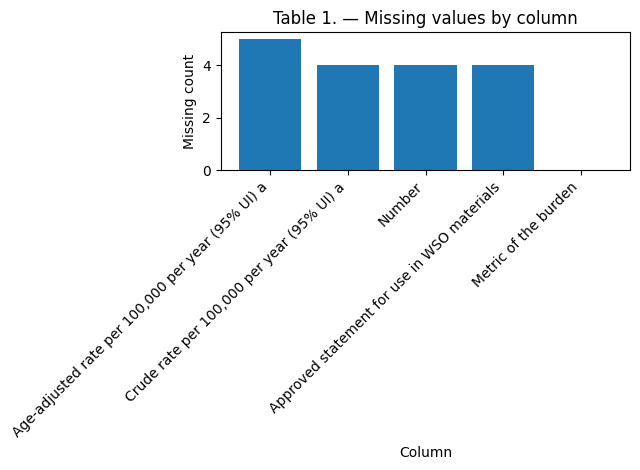

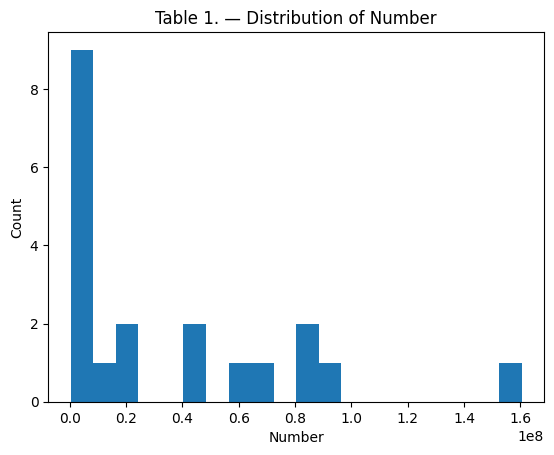

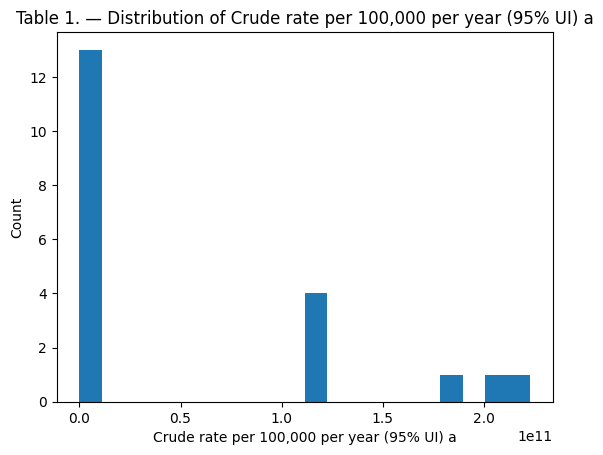

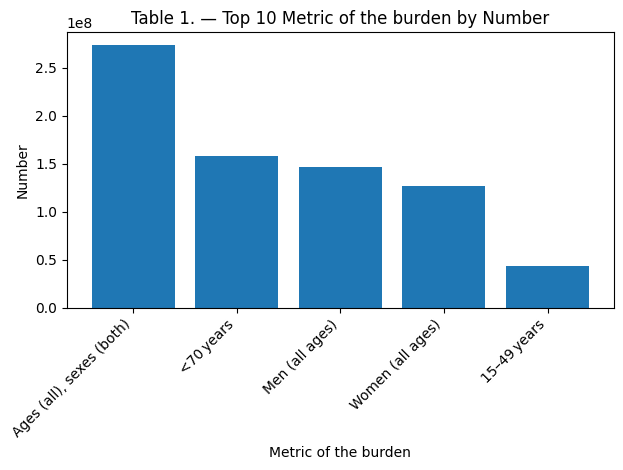


Table 2.
Caption: GBD 2021 estimates for global incidence, prevalence, mortality, and DALYs for IS.


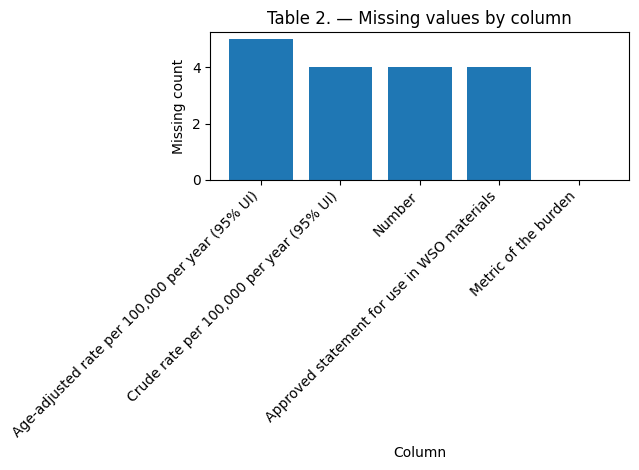

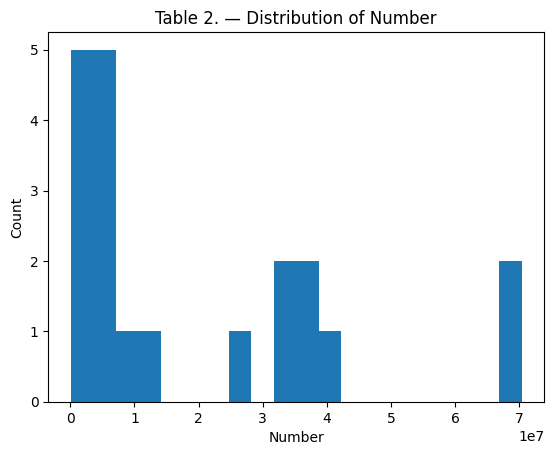

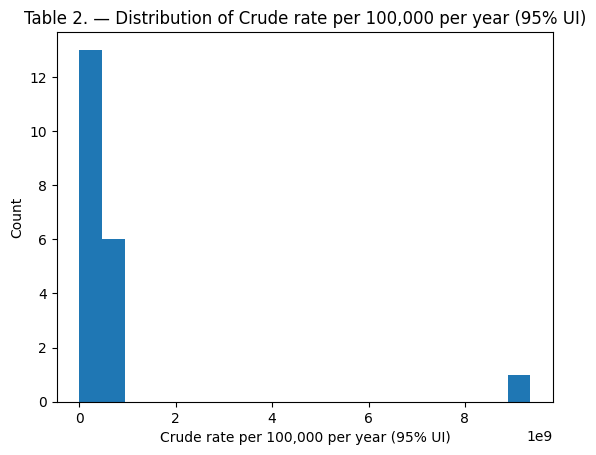

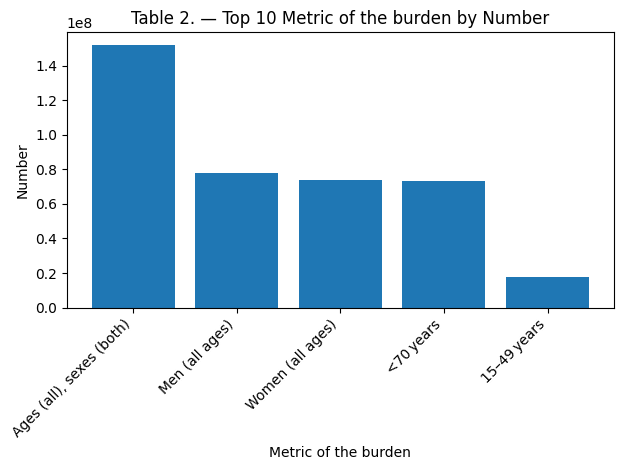


Table 3.
Caption: GBD 2021 estimates for global incidence, prevalence, mortality, and DALYs for ICH.


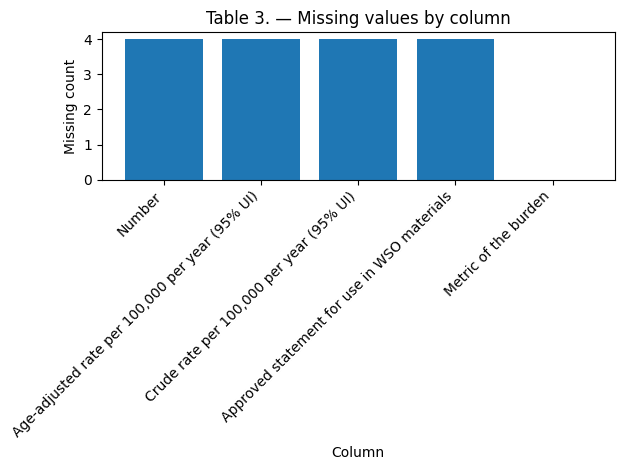

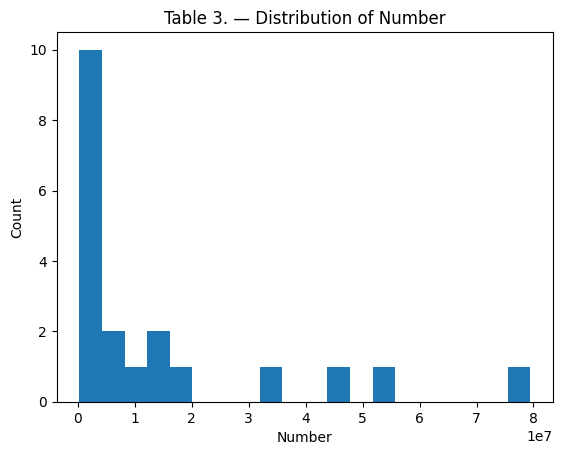

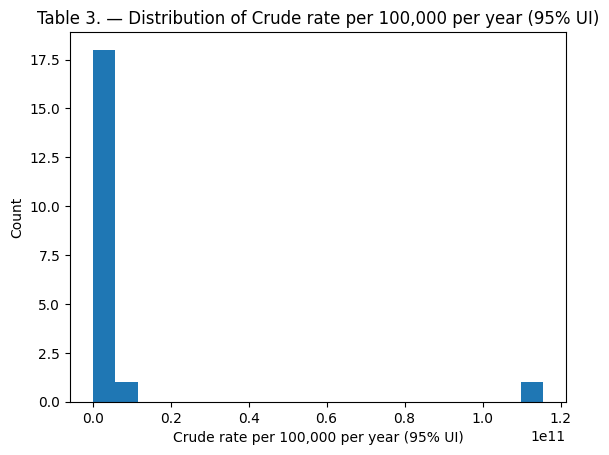

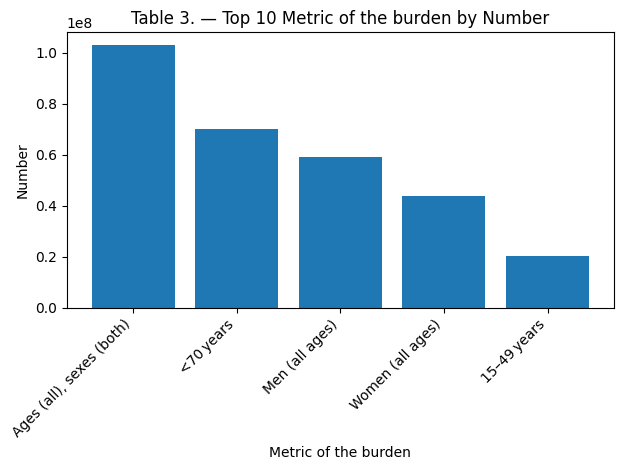


Table 4.
Caption: GBD 2021 estimates for global incidence, prevalence, mortality, and DALYs for SAH.


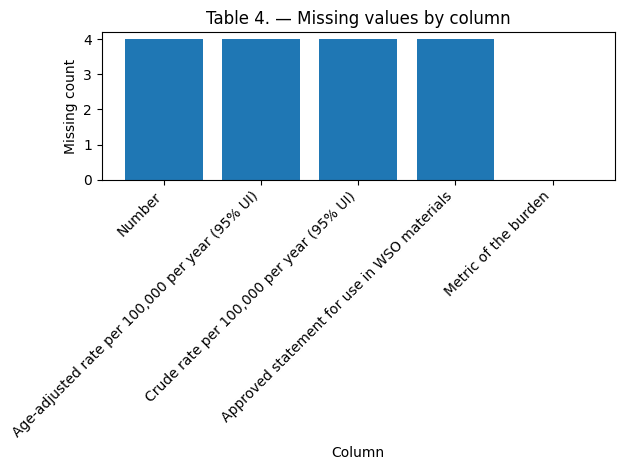

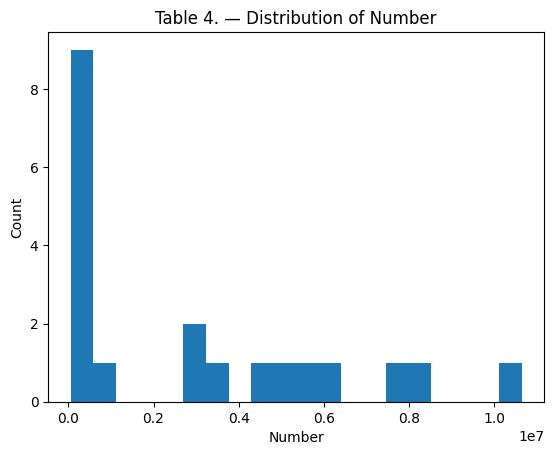

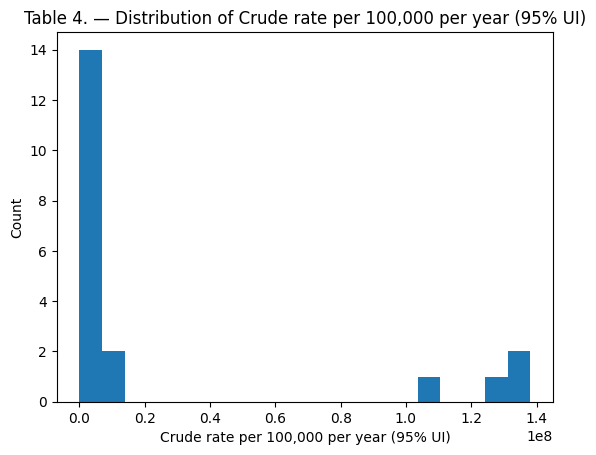

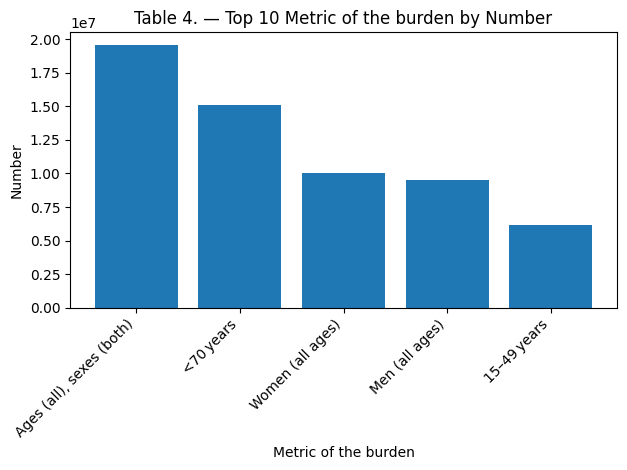


Table 5.
Caption: 2021 GBD estimates for stroke burden (as measured by DALYs) attributable to risk factors.
[Table 5.] No missing values.
[Table 5.] No numeric columns detected to plot histograms.
[Table 5.] No numeric columns detected for bar plot.


In [11]:
for label, caption, df in tables:
    print("\n" + "="*80)
    print(label)
    print("Caption:", (caption[:200] + "...") if len(caption) > 200 else caption)

    plot_table_missingness(label, df)
    plot_numeric_histograms(label, df, max_cols=2)
    plot_top_categories_bar(label, df, top_n=10)
